In [1]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# Config

In [2]:
# Load
X_train = torch.load('Data/X_train_new.pt')
X_val = torch.load('Data/X_val_new.pt')
X_test = torch.load('Data/X_test_new.pt')
y_train = torch.load('Data/y_train_new.pt')
y_val = torch.load('Data/y_val_new.pt')
y_test = torch.load('Data/y_test_new.pt')

In [3]:
BATCH_SIZE_TRAIN = 256  # 32 -> 256
BATCH_SIZE_VAL = 512
BATCH_SIZE_TEST = 512

RE_SIZE = 96
INPUT_CH = 1    # Must be 1
NUM_CLASSES = 9
IS_PRETRAINED = False
LEARNING_RATE = 1e-4
EPOCHS = 80

save_name = f'resnet50_batch{BATCH_SIZE_TRAIN}_aug_focalv2'
save_path = f'models/{save_name}.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(save_name, save_path)

resnet50_batch256_aug_focalv2 models/resnet50_batch256_aug_focalv2.pt


# Dataset

In [4]:
from albumentations.pytorch.transforms import ToTensorV2
from utils import get_transforms, display_aug
# Transforms and Dataset

class WaferDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        # X = self.df.waferMap.values[idx]
        # y = self.df.failureNum.values[idx].int()

        if self.transform:
            X = self.transform(image=X)
            
        return {
            'img' : X['image'], 
            'label': y
        }

train_transform, else_transform = get_transforms(size=RE_SIZE)

train_dataset = WaferDataset(X_train, y_train, transform=train_transform)
val_dataset = WaferDataset(X_val, y_val, transform=else_transform)
test_dataset = WaferDataset(X_test, y_test, transform=else_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

24863 5328 5328


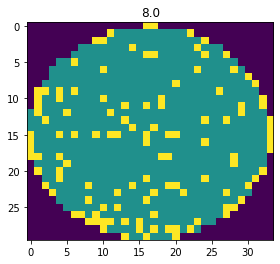

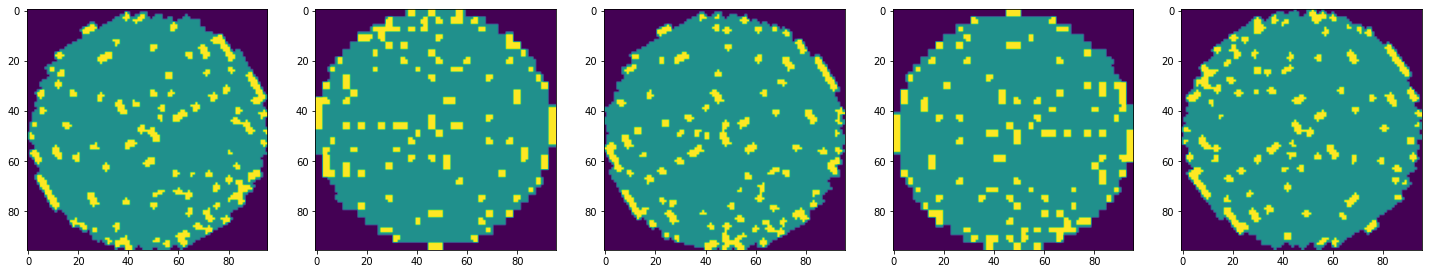

In [5]:
display_aug(imgs=X_train, transform=train_transform, labels = y_train)

# Model

In [7]:
from torchvision.models import resnet50
from torchinfo import summary

model = resnet50(pretrained=IS_PRETRAINED)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)
# summary(model, (BATCH_SIZE_TRAIN, INPUT_CH, RE_SIZE, RE_SIZE), device='cpu')

In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights,dtype=torch.float)

In [9]:
np.unique(y_train)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [10]:
np.unique(y_train, return_counts=True)[1]

array([3006,  389, 3632, 6776, 2515,  606,  835,  104, 7000], dtype=int64)

In [11]:
sqrt_weights = torch.sqrt(weights)
print(weights)
print(sqrt_weights)

tensor([ 0.9190,  7.1017,  0.7606,  0.4077,  1.0984,  4.5587,  3.3084, 26.5630,
         0.3947])
tensor([0.9587, 2.6649, 0.8721, 0.6385, 1.0481, 2.1351, 1.8189, 5.1539, 0.6282])


In [14]:
np.unique(y_train, return_counts=True)[1] * np.array(weights)

array([2762.5554775 , 2762.55548334, 2762.55559635, 2762.55562663,
       2762.55544186, 2762.55549145, 2762.55553722, 2762.55554199,
       2762.55550981])

In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils import FocalLoss

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = FocalLoss(weights=sqrt_weights.cuda(), gamma=2, reduce=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.1, patience=5, cooldown=3, threshold_mode='rel', verbose=True)

In [16]:
from sklearn.metrics import f1_score 

def train(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    scaler = torch.cuda.amp.GradScaler()
    tqdm_loader = tqdm(enumerate(loader))
    model.train()
    for batch_idx, batch in tqdm_loader:
        img = batch['img'].float().cuda()
        label = batch['label'].long().cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # mixed precision + gradient clipping
        with torch.cuda.amp.autocast():
            output = model(img).cuda()
            loss = criterion(output, label)

        scaler.scale(loss).backward() 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        scaler.step(optimizer)
        scaler.update()
        
        # # forward + backward + optimize
        # output = model(img)
        # loss = criterion(output, label)
        # loss.backward()
        # optimizer.step()
        
        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects += correct
        running_num += len(label)
        
        for item in label.cpu().numpy():
            y_true.append(item)
        for item in preds.cpu().numpy():
            y_pred.append(item)
        
        tqdm_loader.set_postfix({
            'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            'Batch Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            'Batch ACC': '{:06f}'.format(correct / len(label)),
            'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_corrects / running_num
    epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f} lr: {optimizer.param_groups[0]["lr"]:.6f}')
    
def evaluate(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            img = batch['img'].float().cuda()   
            label = batch['label'].long().cuda()
            output = model(img).cuda()
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects += correct
            running_num += len(label)

            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

            # tqdm_loader.set_postfix({
            #     'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            #     'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            #     'Batch Loss': '{:06f}'.format(loss.item()),
            #     'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            #     'Batch ACC': '{:06f}'.format(correct / len(label)),
            #     'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
            # })

        epoch_loss = running_loss / len(loader)
        epoch_acc = running_corrects / running_num
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        scheduler.step(epoch_loss)
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'{running_corrects}/{running_num} correct')
        
        epoch_acc = epoch_acc.detach().cpu().numpy()    # tensor->numpy
        val_acc_list.append(epoch_acc)
        val_f1_macro_list.append(epoch_f1_macro)
        val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_f1_macro_list) == val_f1_macro_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)   # weighted F1 기준


# Train

In [17]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)

val_acc_list = []
val_f1_macro_list = []
val_f1_weighted_list = []

model = model.cuda()

for epoch in range(EPOCHS):
    train(model, train_loader, epoch, EPOCHS)
    evaluate(model, val_loader, epoch, EPOCHS)

98it [00:13,  7.13it/s, Epoch=1/80, Batch=98/98, Batch Loss=1.292821, Mean Loss=0.816551, Batch ACC=0.612903, Mean ACC=0.515465]


Train loss: 0.816551, Train ACC: 0.515465, F1_macro: 0.399102, F1_weighted: 0.505272 lr: 0.000100
Valid loss: 0.643477, Valid ACC: 0.616554, F1_macro: 0.468609, F1_weighted: 0.615437
3285/5328 correct


98it [00:10,  9.05it/s, Epoch=2/80, Batch=98/98, Batch Loss=0.511138, Mean Loss=0.524228, Batch ACC=0.612903, Mean ACC=0.658690]


Train loss: 0.524228, Train ACC: 0.658690, F1_macro: 0.577370, F1_weighted: 0.663564 lr: 0.000100
Valid loss: 0.442936, Valid ACC: 0.689565, F1_macro: 0.611172, F1_weighted: 0.695700
3674/5328 correct


98it [00:10,  8.93it/s, Epoch=3/80, Batch=98/98, Batch Loss=0.491423, Mean Loss=0.418271, Batch ACC=0.709677, Mean ACC=0.713269]


Train loss: 0.418271, Train ACC: 0.713269, F1_macro: 0.644598, F1_weighted: 0.716929 lr: 0.000100
Valid loss: 0.394712, Valid ACC: 0.752815, F1_macro: 0.688018, F1_weighted: 0.750259
4011/5328 correct


98it [00:10,  8.93it/s, Epoch=4/80, Batch=98/98, Batch Loss=0.489035, Mean Loss=0.350723, Batch ACC=0.709677, Mean ACC=0.757350]


Train loss: 0.350723, Train ACC: 0.757350, F1_macro: 0.689637, F1_weighted: 0.761932 lr: 0.000100
Valid loss: 0.324126, Valid ACC: 0.792605, F1_macro: 0.713655, F1_weighted: 0.787810
4223/5328 correct


98it [00:10,  8.94it/s, Epoch=5/80, Batch=98/98, Batch Loss=0.590966, Mean Loss=0.313056, Batch ACC=0.612903, Mean ACC=0.772111]


Train loss: 0.313056, Train ACC: 0.772111, F1_macro: 0.713605, F1_weighted: 0.778880 lr: 0.000100
Valid loss: 0.291076, Valid ACC: 0.795608, F1_macro: 0.748496, F1_weighted: 0.801062
4239/5328 correct


98it [00:10,  8.98it/s, Epoch=6/80, Batch=98/98, Batch Loss=0.244163, Mean Loss=0.282866, Batch ACC=0.774194, Mean ACC=0.786591]


Train loss: 0.282866, Train ACC: 0.786591, F1_macro: 0.724764, F1_weighted: 0.794967 lr: 0.000100
Valid loss: 0.260474, Valid ACC: 0.824887, F1_macro: 0.755807, F1_weighted: 0.825547
4395/5328 correct


98it [00:11,  8.76it/s, Epoch=7/80, Batch=98/98, Batch Loss=0.626394, Mean Loss=0.262315, Batch ACC=0.774194, Mean ACC=0.808511]


Train loss: 0.262315, Train ACC: 0.808511, F1_macro: 0.740824, F1_weighted: 0.816528 lr: 0.000100
Valid loss: 0.252559, Valid ACC: 0.838776, F1_macro: 0.771535, F1_weighted: 0.837547
4469/5328 correct


98it [00:10,  8.98it/s, Epoch=8/80, Batch=98/98, Batch Loss=0.287046, Mean Loss=0.230687, Batch ACC=0.806452, Mean ACC=0.826369]


Train loss: 0.230687, Train ACC: 0.826369, F1_macro: 0.769893, F1_weighted: 0.834366 lr: 0.000100
Valid loss: 0.226750, Valid ACC: 0.849287, F1_macro: 0.782239, F1_weighted: 0.849207
4525/5328 correct


98it [00:10,  9.01it/s, Epoch=9/80, Batch=98/98, Batch Loss=0.104885, Mean Loss=0.212624, Batch ACC=0.870968, Mean ACC=0.831637]


Train loss: 0.212624, Train ACC: 0.831637, F1_macro: 0.778483, F1_weighted: 0.840577 lr: 0.000100
Valid loss: 0.216792, Valid ACC: 0.853604, F1_macro: 0.796261, F1_weighted: 0.859016
4548/5328 correct


98it [00:11,  8.89it/s, Epoch=10/80, Batch=98/98, Batch Loss=0.193830, Mean Loss=0.206415, Batch ACC=0.838710, Mean ACC=0.840767]


Train loss: 0.206415, Train ACC: 0.840767, F1_macro: 0.783898, F1_weighted: 0.848410 lr: 0.000100
Valid loss: 0.216705, Valid ACC: 0.856794, F1_macro: 0.780395, F1_weighted: 0.859125
4565/5328 correct


98it [00:11,  8.72it/s, Epoch=11/80, Batch=98/98, Batch Loss=0.137243, Mean Loss=0.193862, Batch ACC=0.870968, Mean ACC=0.847002]


Train loss: 0.193862, Train ACC: 0.847002, F1_macro: 0.792203, F1_weighted: 0.854728 lr: 0.000100
Valid loss: 0.203547, Valid ACC: 0.866554, F1_macro: 0.810182, F1_weighted: 0.868926
4617/5328 correct


98it [00:10,  9.02it/s, Epoch=12/80, Batch=98/98, Batch Loss=0.053622, Mean Loss=0.170981, Batch ACC=0.967742, Mean ACC=0.858384]


Train loss: 0.170981, Train ACC: 0.858384, F1_macro: 0.811574, F1_weighted: 0.865939 lr: 0.000100
Valid loss: 0.184757, Valid ACC: 0.881944, F1_macro: 0.817581, F1_weighted: 0.880959
4699/5328 correct


98it [00:11,  8.78it/s, Epoch=13/80, Batch=98/98, Batch Loss=0.163308, Mean Loss=0.169394, Batch ACC=0.709677, Mean ACC=0.861843]


Train loss: 0.169394, Train ACC: 0.861843, F1_macro: 0.811659, F1_weighted: 0.868868 lr: 0.000100
Valid loss: 0.181591, Valid ACC: 0.871434, F1_macro: 0.812994, F1_weighted: 0.873848
4643/5328 correct


98it [00:11,  8.90it/s, Epoch=14/80, Batch=98/98, Batch Loss=0.097132, Mean Loss=0.160558, Batch ACC=0.903226, Mean ACC=0.865342]


Train loss: 0.160558, Train ACC: 0.865342, F1_macro: 0.820260, F1_weighted: 0.872070 lr: 0.000100
Valid loss: 0.162244, Valid ACC: 0.876689, F1_macro: 0.825394, F1_weighted: 0.880533
4671/5328 correct


98it [00:10,  8.98it/s, Epoch=15/80, Batch=98/98, Batch Loss=0.044154, Mean Loss=0.153903, Batch ACC=0.903226, Mean ACC=0.868962]


Train loss: 0.153903, Train ACC: 0.868962, F1_macro: 0.824911, F1_weighted: 0.875202 lr: 0.000100
Valid loss: 0.173783, Valid ACC: 0.860923, F1_macro: 0.798070, F1_weighted: 0.864341
4587/5328 correct


98it [00:11,  8.86it/s, Epoch=16/80, Batch=98/98, Batch Loss=0.063505, Mean Loss=0.152566, Batch ACC=0.935484, Mean ACC=0.872139]


Train loss: 0.152566, Train ACC: 0.872139, F1_macro: 0.827596, F1_weighted: 0.878457 lr: 0.000100
Valid loss: 0.183490, Valid ACC: 0.886449, F1_macro: 0.793880, F1_weighted: 0.888756
4723/5328 correct


98it [00:11,  8.85it/s, Epoch=17/80, Batch=98/98, Batch Loss=0.102562, Mean Loss=0.145394, Batch ACC=0.838710, Mean ACC=0.879138]


Train loss: 0.145394, Train ACC: 0.879138, F1_macro: 0.834461, F1_weighted: 0.884566 lr: 0.000100
Valid loss: 0.160064, Valid ACC: 0.877065, F1_macro: 0.823584, F1_weighted: 0.880901
4673/5328 correct


98it [00:11,  8.91it/s, Epoch=18/80, Batch=98/98, Batch Loss=0.086208, Mean Loss=0.141468, Batch ACC=0.935484, Mean ACC=0.881511]


Train loss: 0.141468, Train ACC: 0.881511, F1_macro: 0.835589, F1_weighted: 0.887320 lr: 0.000100
Valid loss: 0.194422, Valid ACC: 0.871997, F1_macro: 0.793747, F1_weighted: 0.878400
4646/5328 correct


98it [00:11,  8.79it/s, Epoch=19/80, Batch=98/98, Batch Loss=0.127730, Mean Loss=0.136198, Batch ACC=0.935484, Mean ACC=0.880666]


Train loss: 0.136198, Train ACC: 0.880666, F1_macro: 0.838680, F1_weighted: 0.886500 lr: 0.000100
Valid loss: 0.145834, Valid ACC: 0.893956, F1_macro: 0.848464, F1_weighted: 0.896414
4763/5328 correct


98it [00:11,  8.83it/s, Epoch=20/80, Batch=98/98, Batch Loss=0.063321, Mean Loss=0.136871, Batch ACC=0.903226, Mean ACC=0.885814]


Train loss: 0.136871, Train ACC: 0.885814, F1_macro: 0.839708, F1_weighted: 0.891119 lr: 0.000100
Valid loss: 0.154868, Valid ACC: 0.868806, F1_macro: 0.814744, F1_weighted: 0.876766
4629/5328 correct


98it [00:10,  9.00it/s, Epoch=21/80, Batch=98/98, Batch Loss=0.205818, Mean Loss=0.132492, Batch ACC=0.903226, Mean ACC=0.887544]


Train loss: 0.132492, Train ACC: 0.887544, F1_macro: 0.840251, F1_weighted: 0.892336 lr: 0.000100
Valid loss: 0.146888, Valid ACC: 0.889640, F1_macro: 0.831543, F1_weighted: 0.893250
4740/5328 correct


98it [00:10,  9.05it/s, Epoch=22/80, Batch=98/98, Batch Loss=0.204064, Mean Loss=0.130424, Batch ACC=0.870968, Mean ACC=0.887021]


Train loss: 0.130424, Train ACC: 0.887021, F1_macro: 0.844417, F1_weighted: 0.892253 lr: 0.000100
Valid loss: 0.154367, Valid ACC: 0.878378, F1_macro: 0.828515, F1_weighted: 0.881356
4680/5328 correct


98it [00:10,  9.00it/s, Epoch=23/80, Batch=98/98, Batch Loss=0.096398, Mean Loss=0.126550, Batch ACC=0.806452, Mean ACC=0.890922]


Train loss: 0.126550, Train ACC: 0.890922, F1_macro: 0.846780, F1_weighted: 0.895727 lr: 0.000100
Valid loss: 0.146267, Valid ACC: 0.882695, F1_macro: 0.823748, F1_weighted: 0.888168
4703/5328 correct


98it [00:10,  8.95it/s, Epoch=24/80, Batch=98/98, Batch Loss=0.051799, Mean Loss=0.123593, Batch ACC=0.935484, Mean ACC=0.892933]


Train loss: 0.123593, Train ACC: 0.892933, F1_macro: 0.849625, F1_weighted: 0.897807 lr: 0.000100
Valid loss: 0.147232, Valid ACC: 0.903529, F1_macro: 0.850059, F1_weighted: 0.904932
4814/5328 correct


98it [00:10,  8.98it/s, Epoch=25/80, Batch=98/98, Batch Loss=0.070250, Mean Loss=0.118227, Batch ACC=0.903226, Mean ACC=0.890761]


Train loss: 0.118227, Train ACC: 0.890761, F1_macro: 0.853326, F1_weighted: 0.895656 lr: 0.000100
Epoch    25: reducing learning rate of group 0 to 5.0000e-05.
Valid loss: 0.132975, Valid ACC: 0.897147, F1_macro: 0.855482, F1_weighted: 0.901657
4780/5328 correct


98it [00:10,  9.23it/s, Epoch=26/80, Batch=98/98, Batch Loss=0.099100, Mean Loss=0.104760, Batch ACC=0.870968, Mean ACC=0.904597]


Train loss: 0.104760, Train ACC: 0.904597, F1_macro: 0.871737, F1_weighted: 0.908136 lr: 0.000050
Valid loss: 0.129139, Valid ACC: 0.903153, F1_macro: 0.862430, F1_weighted: 0.906059
4812/5328 correct


98it [00:10,  9.20it/s, Epoch=27/80, Batch=98/98, Batch Loss=0.108017, Mean Loss=0.101562, Batch ACC=0.935484, Mean ACC=0.904919]


Train loss: 0.101562, Train ACC: 0.904919, F1_macro: 0.873543, F1_weighted: 0.908383 lr: 0.000050
Valid loss: 0.122480, Valid ACC: 0.906344, F1_macro: 0.863077, F1_weighted: 0.907952
4829/5328 correct


98it [00:10,  9.21it/s, Epoch=28/80, Batch=98/98, Batch Loss=0.316425, Mean Loss=0.103925, Batch ACC=0.870968, Mean ACC=0.909102]


Train loss: 0.103925, Train ACC: 0.909102, F1_macro: 0.872981, F1_weighted: 0.912343 lr: 0.000050
Valid loss: 0.134337, Valid ACC: 0.898649, F1_macro: 0.833026, F1_weighted: 0.902510
4788/5328 correct


98it [00:10,  9.19it/s, Epoch=29/80, Batch=98/98, Batch Loss=0.050329, Mean Loss=0.095695, Batch ACC=0.935484, Mean ACC=0.912360]


Train loss: 0.095695, Train ACC: 0.912360, F1_macro: 0.878024, F1_weighted: 0.915427 lr: 0.000050
Valid loss: 0.120384, Valid ACC: 0.905030, F1_macro: 0.865597, F1_weighted: 0.908051
4822/5328 correct


98it [00:10,  9.19it/s, Epoch=30/80, Batch=98/98, Batch Loss=0.034493, Mean Loss=0.094205, Batch ACC=0.935484, Mean ACC=0.910791]


Train loss: 0.094205, Train ACC: 0.910791, F1_macro: 0.881906, F1_weighted: 0.913835 lr: 0.000050
Valid loss: 0.127137, Valid ACC: 0.909910, F1_macro: 0.866720, F1_weighted: 0.910553
4848/5328 correct


98it [00:10,  9.16it/s, Epoch=31/80, Batch=98/98, Batch Loss=0.153592, Mean Loss=0.093557, Batch ACC=0.774194, Mean ACC=0.917548]


Train loss: 0.093557, Train ACC: 0.917548, F1_macro: 0.884226, F1_weighted: 0.919956 lr: 0.000050
Valid loss: 0.118899, Valid ACC: 0.910285, F1_macro: 0.867897, F1_weighted: 0.912059
4850/5328 correct


98it [00:10,  9.13it/s, Epoch=32/80, Batch=98/98, Batch Loss=0.045642, Mean Loss=0.092161, Batch ACC=0.870968, Mean ACC=0.914934]


Train loss: 0.092161, Train ACC: 0.914934, F1_macro: 0.882055, F1_weighted: 0.917645 lr: 0.000050
Valid loss: 0.117164, Valid ACC: 0.899775, F1_macro: 0.854742, F1_weighted: 0.902763
4794/5328 correct


98it [00:10,  9.20it/s, Epoch=33/80, Batch=98/98, Batch Loss=0.030526, Mean Loss=0.088290, Batch ACC=0.967742, Mean ACC=0.916422]


Train loss: 0.088290, Train ACC: 0.916422, F1_macro: 0.886912, F1_weighted: 0.919126 lr: 0.000050
Valid loss: 0.125084, Valid ACC: 0.911599, F1_macro: 0.867058, F1_weighted: 0.912678
4857/5328 correct


98it [00:10,  9.19it/s, Epoch=34/80, Batch=98/98, Batch Loss=0.146531, Mean Loss=0.089299, Batch ACC=0.935484, Mean ACC=0.918875]


Train loss: 0.089299, Train ACC: 0.918875, F1_macro: 0.889542, F1_weighted: 0.921433 lr: 0.000050
Valid loss: 0.114530, Valid ACC: 0.909910, F1_macro: 0.867128, F1_weighted: 0.911262
4848/5328 correct


98it [00:10,  9.18it/s, Epoch=35/80, Batch=98/98, Batch Loss=0.643263, Mean Loss=0.091955, Batch ACC=0.806452, Mean ACC=0.918755]


Train loss: 0.091955, Train ACC: 0.918755, F1_macro: 0.894474, F1_weighted: 0.921298 lr: 0.000050
Valid loss: 0.129557, Valid ACC: 0.911974, F1_macro: 0.873883, F1_weighted: 0.913479
4859/5328 correct


98it [00:10,  9.06it/s, Epoch=36/80, Batch=98/98, Batch Loss=0.038139, Mean Loss=0.087604, Batch ACC=0.967742, Mean ACC=0.918634]


Train loss: 0.087604, Train ACC: 0.918634, F1_macro: 0.884368, F1_weighted: 0.921209 lr: 0.000050
Valid loss: 0.111772, Valid ACC: 0.908784, F1_macro: 0.870840, F1_weighted: 0.910621
4842/5328 correct


98it [00:10,  8.95it/s, Epoch=37/80, Batch=98/98, Batch Loss=0.061023, Mean Loss=0.083066, Batch ACC=0.967742, Mean ACC=0.919640]


Train loss: 0.083066, Train ACC: 0.919640, F1_macro: 0.892568, F1_weighted: 0.921910 lr: 0.000050
Valid loss: 0.117378, Valid ACC: 0.905030, F1_macro: 0.856137, F1_weighted: 0.908142
4822/5328 correct


98it [00:10,  9.00it/s, Epoch=38/80, Batch=98/98, Batch Loss=0.042910, Mean Loss=0.083572, Batch ACC=0.935484, Mean ACC=0.920082]


Train loss: 0.083572, Train ACC: 0.920082, F1_macro: 0.892048, F1_weighted: 0.922254 lr: 0.000050
Valid loss: 0.108762, Valid ACC: 0.913851, F1_macro: 0.874424, F1_weighted: 0.915634
4869/5328 correct


98it [00:10,  9.08it/s, Epoch=39/80, Batch=98/98, Batch Loss=0.117935, Mean Loss=0.081681, Batch ACC=0.935484, Mean ACC=0.923541]


Train loss: 0.081681, Train ACC: 0.923541, F1_macro: 0.895642, F1_weighted: 0.925426 lr: 0.000050
Valid loss: 0.117510, Valid ACC: 0.910473, F1_macro: 0.868411, F1_weighted: 0.913052
4851/5328 correct


98it [00:10,  8.94it/s, Epoch=40/80, Batch=98/98, Batch Loss=0.035614, Mean Loss=0.081423, Batch ACC=0.903226, Mean ACC=0.922857]


Train loss: 0.081423, Train ACC: 0.922857, F1_macro: 0.893116, F1_weighted: 0.924733 lr: 0.000050
Epoch    40: reducing learning rate of group 0 to 2.5000e-05.
Valid loss: 0.111236, Valid ACC: 0.907658, F1_macro: 0.859788, F1_weighted: 0.910332
4836/5328 correct


98it [00:10,  9.04it/s, Epoch=41/80, Batch=98/98, Batch Loss=0.131862, Mean Loss=0.075216, Batch ACC=0.903226, Mean ACC=0.927040]


Train loss: 0.075216, Train ACC: 0.927040, F1_macro: 0.905969, F1_weighted: 0.929103 lr: 0.000025
Valid loss: 0.106976, Valid ACC: 0.919482, F1_macro: 0.886173, F1_weighted: 0.920479
4899/5328 correct


98it [00:10,  8.91it/s, Epoch=42/80, Batch=98/98, Batch Loss=0.084068, Mean Loss=0.074111, Batch ACC=0.870968, Mean ACC=0.926799]


Train loss: 0.074111, Train ACC: 0.926799, F1_macro: 0.903124, F1_weighted: 0.928823 lr: 0.000025
Valid loss: 0.110959, Valid ACC: 0.917042, F1_macro: 0.871978, F1_weighted: 0.917996
4886/5328 correct


98it [00:11,  8.89it/s, Epoch=43/80, Batch=98/98, Batch Loss=0.139123, Mean Loss=0.072371, Batch ACC=0.935484, Mean ACC=0.931183]


Train loss: 0.072371, Train ACC: 0.931183, F1_macro: 0.910211, F1_weighted: 0.932858 lr: 0.000025
Valid loss: 0.106789, Valid ACC: 0.917230, F1_macro: 0.875538, F1_weighted: 0.919195
4887/5328 correct


98it [00:11,  8.86it/s, Epoch=44/80, Batch=98/98, Batch Loss=0.201337, Mean Loss=0.073812, Batch ACC=0.741935, Mean ACC=0.932671]


Train loss: 0.073812, Train ACC: 0.932671, F1_macro: 0.907264, F1_weighted: 0.934199 lr: 0.000025
Valid loss: 0.111074, Valid ACC: 0.910848, F1_macro: 0.874699, F1_weighted: 0.911959
4853/5328 correct


98it [00:11,  8.79it/s, Epoch=45/80, Batch=98/98, Batch Loss=0.138082, Mean Loss=0.069905, Batch ACC=0.838710, Mean ACC=0.933315]


Train loss: 0.069905, Train ACC: 0.933315, F1_macro: 0.911915, F1_weighted: 0.934968 lr: 0.000025
Valid loss: 0.104696, Valid ACC: 0.920608, F1_macro: 0.881764, F1_weighted: 0.921003
4905/5328 correct


98it [00:11,  8.79it/s, Epoch=46/80, Batch=98/98, Batch Loss=0.143157, Mean Loss=0.069631, Batch ACC=0.806452, Mean ACC=0.932550]


Train loss: 0.069631, Train ACC: 0.932550, F1_macro: 0.907762, F1_weighted: 0.934021 lr: 0.000025
Valid loss: 0.105940, Valid ACC: 0.922110, F1_macro: 0.884127, F1_weighted: 0.923190
4913/5328 correct


98it [00:11,  8.84it/s, Epoch=47/80, Batch=98/98, Batch Loss=0.277925, Mean Loss=0.071743, Batch ACC=0.903226, Mean ACC=0.932309]


Train loss: 0.071743, Train ACC: 0.932309, F1_macro: 0.911122, F1_weighted: 0.934011 lr: 0.000025
Valid loss: 0.102708, Valid ACC: 0.921359, F1_macro: 0.885248, F1_weighted: 0.922068
4909/5328 correct


98it [00:10,  8.92it/s, Epoch=48/80, Batch=98/98, Batch Loss=0.081637, Mean Loss=0.070951, Batch ACC=0.935484, Mean ACC=0.933114]


Train loss: 0.070951, Train ACC: 0.933114, F1_macro: 0.913845, F1_weighted: 0.934524 lr: 0.000025
Valid loss: 0.107700, Valid ACC: 0.921171, F1_macro: 0.883083, F1_weighted: 0.921529
4908/5328 correct


98it [00:11,  8.78it/s, Epoch=49/80, Batch=98/98, Batch Loss=0.076472, Mean Loss=0.067711, Batch ACC=0.935484, Mean ACC=0.934039]


Train loss: 0.067711, Train ACC: 0.934039, F1_macro: 0.912432, F1_weighted: 0.935416 lr: 0.000025
Valid loss: 0.107372, Valid ACC: 0.918544, F1_macro: 0.877319, F1_weighted: 0.919338
4894/5328 correct


98it [00:10,  8.94it/s, Epoch=50/80, Batch=98/98, Batch Loss=0.118970, Mean Loss=0.070196, Batch ACC=0.870968, Mean ACC=0.934481]


Train loss: 0.070196, Train ACC: 0.934481, F1_macro: 0.911076, F1_weighted: 0.935945 lr: 0.000025
Valid loss: 0.106512, Valid ACC: 0.917230, F1_macro: 0.877949, F1_weighted: 0.918878
4887/5328 correct


98it [00:11,  8.90it/s, Epoch=51/80, Batch=98/98, Batch Loss=0.131745, Mean Loss=0.067414, Batch ACC=0.806452, Mean ACC=0.935486]


Train loss: 0.067414, Train ACC: 0.935486, F1_macro: 0.911063, F1_weighted: 0.936832 lr: 0.000025
Valid loss: 0.103555, Valid ACC: 0.920796, F1_macro: 0.883905, F1_weighted: 0.921761
4906/5328 correct


98it [00:11,  8.82it/s, Epoch=52/80, Batch=98/98, Batch Loss=0.130618, Mean Loss=0.065447, Batch ACC=0.838710, Mean ACC=0.934602]


Train loss: 0.065447, Train ACC: 0.934602, F1_macro: 0.912668, F1_weighted: 0.936238 lr: 0.000025
Valid loss: 0.107774, Valid ACC: 0.922860, F1_macro: 0.883813, F1_weighted: 0.923503
4917/5328 correct


98it [00:11,  8.77it/s, Epoch=53/80, Batch=98/98, Batch Loss=0.499991, Mean Loss=0.069994, Batch ACC=0.903226, Mean ACC=0.935688]


Train loss: 0.069994, Train ACC: 0.935688, F1_macro: 0.911355, F1_weighted: 0.936956 lr: 0.000025
Epoch    53: reducing learning rate of group 0 to 1.2500e-05.
Valid loss: 0.107571, Valid ACC: 0.923799, F1_macro: 0.892595, F1_weighted: 0.924237
4922/5328 correct


98it [00:11,  8.79it/s, Epoch=54/80, Batch=98/98, Batch Loss=0.044523, Mean Loss=0.061539, Batch ACC=0.903226, Mean ACC=0.936693]


Train loss: 0.061539, Train ACC: 0.936693, F1_macro: 0.919331, F1_weighted: 0.937782 lr: 0.000013
Valid loss: 0.104454, Valid ACC: 0.922860, F1_macro: 0.887749, F1_weighted: 0.923754
4917/5328 correct


98it [00:11,  8.69it/s, Epoch=55/80, Batch=98/98, Batch Loss=0.097262, Mean Loss=0.062740, Batch ACC=0.870968, Mean ACC=0.939227]


Train loss: 0.062740, Train ACC: 0.939227, F1_macro: 0.918521, F1_weighted: 0.940483 lr: 0.000013
Valid loss: 0.106401, Valid ACC: 0.922860, F1_macro: 0.885883, F1_weighted: 0.923256
4917/5328 correct


98it [00:10,  8.95it/s, Epoch=56/80, Batch=98/98, Batch Loss=0.104357, Mean Loss=0.061926, Batch ACC=0.935484, Mean ACC=0.940675]


Train loss: 0.061926, Train ACC: 0.940675, F1_macro: 0.921774, F1_weighted: 0.941796 lr: 0.000013
Valid loss: 0.102894, Valid ACC: 0.925863, F1_macro: 0.890008, F1_weighted: 0.926480
4933/5328 correct


98it [00:10,  8.92it/s, Epoch=57/80, Batch=98/98, Batch Loss=0.251705, Mean Loss=0.063205, Batch ACC=0.903226, Mean ACC=0.940956]


Train loss: 0.063205, Train ACC: 0.940956, F1_macro: 0.922867, F1_weighted: 0.942026 lr: 0.000013
Valid loss: 0.104706, Valid ACC: 0.921734, F1_macro: 0.883198, F1_weighted: 0.922258
4911/5328 correct


98it [00:11,  8.89it/s, Epoch=58/80, Batch=98/98, Batch Loss=0.017274, Mean Loss=0.058777, Batch ACC=0.967742, Mean ACC=0.942766]


Train loss: 0.058777, Train ACC: 0.942766, F1_macro: 0.924931, F1_weighted: 0.943789 lr: 0.000013
Valid loss: 0.104712, Valid ACC: 0.923611, F1_macro: 0.888576, F1_weighted: 0.924072
4921/5328 correct


98it [00:11,  8.81it/s, Epoch=59/80, Batch=98/98, Batch Loss=0.073571, Mean Loss=0.059646, Batch ACC=0.967742, Mean ACC=0.941801]


Train loss: 0.059646, Train ACC: 0.941801, F1_macro: 0.923756, F1_weighted: 0.942918 lr: 0.000013
Valid loss: 0.102320, Valid ACC: 0.925863, F1_macro: 0.891319, F1_weighted: 0.926368
4933/5328 correct


98it [00:10,  8.99it/s, Epoch=60/80, Batch=98/98, Batch Loss=0.058615, Mean Loss=0.058994, Batch ACC=0.935484, Mean ACC=0.941761]


Train loss: 0.058994, Train ACC: 0.941761, F1_macro: 0.923848, F1_weighted: 0.942642 lr: 0.000013
Valid loss: 0.100589, Valid ACC: 0.924737, F1_macro: 0.891087, F1_weighted: 0.925388
4927/5328 correct


98it [00:10,  9.02it/s, Epoch=61/80, Batch=98/98, Batch Loss=0.017323, Mean Loss=0.060769, Batch ACC=1.000000, Mean ACC=0.938222]


Train loss: 0.060769, Train ACC: 0.938222, F1_macro: 0.919647, F1_weighted: 0.939445 lr: 0.000013
Valid loss: 0.099507, Valid ACC: 0.923611, F1_macro: 0.890091, F1_weighted: 0.924320
4921/5328 correct


98it [00:11,  8.84it/s, Epoch=62/80, Batch=98/98, Batch Loss=0.071409, Mean Loss=0.059581, Batch ACC=0.967742, Mean ACC=0.942244]


Train loss: 0.059581, Train ACC: 0.942244, F1_macro: 0.925003, F1_weighted: 0.943322 lr: 0.000013
Epoch    62: reducing learning rate of group 0 to 6.2500e-06.
Valid loss: 0.102190, Valid ACC: 0.923236, F1_macro: 0.886105, F1_weighted: 0.924123
4919/5328 correct


98it [00:10,  9.01it/s, Epoch=63/80, Batch=98/98, Batch Loss=0.017332, Mean Loss=0.055844, Batch ACC=0.935484, Mean ACC=0.942967]


Train loss: 0.055844, Train ACC: 0.942967, F1_macro: 0.924610, F1_weighted: 0.944154 lr: 0.000006
Valid loss: 0.103307, Valid ACC: 0.927553, F1_macro: 0.890690, F1_weighted: 0.927791
4942/5328 correct


98it [00:10,  8.99it/s, Epoch=64/80, Batch=98/98, Batch Loss=0.031826, Mean Loss=0.056563, Batch ACC=0.967742, Mean ACC=0.944295]


Train loss: 0.056563, Train ACC: 0.944295, F1_macro: 0.927335, F1_weighted: 0.945262 lr: 0.000006
Valid loss: 0.101053, Valid ACC: 0.926426, F1_macro: 0.892624, F1_weighted: 0.926900
4936/5328 correct


98it [00:10,  8.99it/s, Epoch=65/80, Batch=98/98, Batch Loss=0.249502, Mean Loss=0.058525, Batch ACC=0.870968, Mean ACC=0.944013]


Train loss: 0.058525, Train ACC: 0.944013, F1_macro: 0.925312, F1_weighted: 0.944964 lr: 0.000006
Valid loss: 0.106364, Valid ACC: 0.926426, F1_macro: 0.892777, F1_weighted: 0.926934
4936/5328 correct


98it [00:11,  8.86it/s, Epoch=66/80, Batch=98/98, Batch Loss=0.119962, Mean Loss=0.059144, Batch ACC=1.000000, Mean ACC=0.943812]


Train loss: 0.059144, Train ACC: 0.943812, F1_macro: 0.924571, F1_weighted: 0.944772 lr: 0.000006
Valid loss: 0.103839, Valid ACC: 0.927177, F1_macro: 0.893689, F1_weighted: 0.927496
4940/5328 correct


98it [00:10,  9.00it/s, Epoch=67/80, Batch=98/98, Batch Loss=0.029120, Mean Loss=0.054954, Batch ACC=0.903226, Mean ACC=0.946225]


Train loss: 0.054954, Train ACC: 0.946225, F1_macro: 0.928454, F1_weighted: 0.947144 lr: 0.000006
Valid loss: 0.100971, Valid ACC: 0.925863, F1_macro: 0.890406, F1_weighted: 0.926511
4933/5328 correct


98it [00:10,  8.94it/s, Epoch=68/80, Batch=98/98, Batch Loss=0.084759, Mean Loss=0.053923, Batch ACC=0.935484, Mean ACC=0.947633]


Train loss: 0.053923, Train ACC: 0.947633, F1_macro: 0.929334, F1_weighted: 0.948467 lr: 0.000006
Valid loss: 0.100865, Valid ACC: 0.924737, F1_macro: 0.891262, F1_weighted: 0.925861
4927/5328 correct


98it [00:11,  8.89it/s, Epoch=69/80, Batch=98/98, Batch Loss=0.126276, Mean Loss=0.055647, Batch ACC=0.903226, Mean ACC=0.946145]


Train loss: 0.055647, Train ACC: 0.946145, F1_macro: 0.931421, F1_weighted: 0.947165 lr: 0.000006
Valid loss: 0.102841, Valid ACC: 0.926051, F1_macro: 0.890629, F1_weighted: 0.926541
4934/5328 correct


98it [00:11,  8.86it/s, Epoch=70/80, Batch=98/98, Batch Loss=0.050649, Mean Loss=0.056390, Batch ACC=0.935484, Mean ACC=0.944174]


Train loss: 0.056390, Train ACC: 0.944174, F1_macro: 0.927394, F1_weighted: 0.945042 lr: 0.000006
Valid loss: 0.102016, Valid ACC: 0.927928, F1_macro: 0.895174, F1_weighted: 0.928486
4944/5328 correct


98it [00:10,  8.95it/s, Epoch=71/80, Batch=98/98, Batch Loss=0.101507, Mean Loss=0.057968, Batch ACC=0.935484, Mean ACC=0.945662]


Train loss: 0.057968, Train ACC: 0.945662, F1_macro: 0.928782, F1_weighted: 0.946547 lr: 0.000006
Epoch    71: reducing learning rate of group 0 to 3.1250e-06.
Valid loss: 0.100674, Valid ACC: 0.924737, F1_macro: 0.890592, F1_weighted: 0.925616
4927/5328 correct


98it [00:11,  8.82it/s, Epoch=72/80, Batch=98/98, Batch Loss=0.035468, Mean Loss=0.055192, Batch ACC=0.903226, Mean ACC=0.944979]


Train loss: 0.055192, Train ACC: 0.944979, F1_macro: 0.928655, F1_weighted: 0.945808 lr: 0.000003
Valid loss: 0.099476, Valid ACC: 0.927177, F1_macro: 0.891950, F1_weighted: 0.927655
4940/5328 correct


98it [00:10,  8.92it/s, Epoch=73/80, Batch=98/98, Batch Loss=0.018150, Mean Loss=0.053204, Batch ACC=0.967742, Mean ACC=0.947915]


Train loss: 0.053204, Train ACC: 0.947915, F1_macro: 0.931676, F1_weighted: 0.948717 lr: 0.000003
Valid loss: 0.100377, Valid ACC: 0.926989, F1_macro: 0.892305, F1_weighted: 0.927669
4939/5328 correct


98it [00:11,  8.81it/s, Epoch=74/80, Batch=98/98, Batch Loss=0.076449, Mean Loss=0.051961, Batch ACC=0.838710, Mean ACC=0.949805]


Train loss: 0.051961, Train ACC: 0.949805, F1_macro: 0.935229, F1_weighted: 0.950518 lr: 0.000003
Valid loss: 0.098712, Valid ACC: 0.924550, F1_macro: 0.891284, F1_weighted: 0.925268
4926/5328 correct


98it [00:10,  9.10it/s, Epoch=75/80, Batch=98/98, Batch Loss=0.087637, Mean Loss=0.054750, Batch ACC=0.935484, Mean ACC=0.946869]


Train loss: 0.054750, Train ACC: 0.946869, F1_macro: 0.931414, F1_weighted: 0.947768 lr: 0.000003
Valid loss: 0.101371, Valid ACC: 0.926426, F1_macro: 0.892639, F1_weighted: 0.927077
4936/5328 correct


98it [00:10,  8.96it/s, Epoch=76/80, Batch=98/98, Batch Loss=0.334449, Mean Loss=0.055006, Batch ACC=0.741935, Mean ACC=0.947593]


Train loss: 0.055006, Train ACC: 0.947593, F1_macro: 0.932024, F1_weighted: 0.948480 lr: 0.000003
Valid loss: 0.100519, Valid ACC: 0.923236, F1_macro: 0.887879, F1_weighted: 0.923949
4919/5328 correct


98it [00:10,  8.94it/s, Epoch=77/80, Batch=98/98, Batch Loss=0.215121, Mean Loss=0.054857, Batch ACC=0.838710, Mean ACC=0.947150]


Train loss: 0.054857, Train ACC: 0.947150, F1_macro: 0.931490, F1_weighted: 0.948039 lr: 0.000003
Valid loss: 0.099850, Valid ACC: 0.925113, F1_macro: 0.889406, F1_weighted: 0.925687
4929/5328 correct


98it [00:10,  9.04it/s, Epoch=78/80, Batch=98/98, Batch Loss=0.055824, Mean Loss=0.056035, Batch ACC=0.967742, Mean ACC=0.945783]


Train loss: 0.056035, Train ACC: 0.945783, F1_macro: 0.928755, F1_weighted: 0.946704 lr: 0.000003
Valid loss: 0.099862, Valid ACC: 0.928303, F1_macro: 0.897537, F1_weighted: 0.928797
4946/5328 correct


98it [00:10,  8.99it/s, Epoch=79/80, Batch=98/98, Batch Loss=0.202745, Mean Loss=0.055153, Batch ACC=0.903226, Mean ACC=0.945381]


Train loss: 0.055153, Train ACC: 0.945381, F1_macro: 0.930121, F1_weighted: 0.946298 lr: 0.000003
Valid loss: 0.099088, Valid ACC: 0.928303, F1_macro: 0.897257, F1_weighted: 0.928909
4946/5328 correct


98it [00:11,  8.84it/s, Epoch=80/80, Batch=98/98, Batch Loss=0.064187, Mean Loss=0.051506, Batch ACC=0.870968, Mean ACC=0.946547]


Train loss: 0.051506, Train ACC: 0.946547, F1_macro: 0.930770, F1_weighted: 0.947419 lr: 0.000003
Epoch    80: reducing learning rate of group 0 to 1.5625e-06.
Valid loss: 0.102694, Valid ACC: 0.927177, F1_macro: 0.892134, F1_weighted: 0.927686
4940/5328 correct


In [18]:
print(max(val_acc_list), max(val_f1_macro_list), max(val_f1_weighted_list))

0.9283033 0.8975366078552507 0.9289086974707279


# Test

In [7]:
def test(model, loader):
    running_loss = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_corrects+=correct
    
            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

        epoch_acc = running_corrects / len(loader.dataset)
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f'{running_corrects}/{len(loader.dataset)} correct')
        print(f'Test ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')

    plt.figure(figsize=(20, 20))
    sns.heatmap(
        confusion_matrix(
            y_true,
            y_pred,
            normalize = 'true'), 
            annot=True, cmap='coolwarm'
            )
    plt.title("CONFUSION MATRIX of the test dataset", fontsize=25)
    plt.show()


In [8]:
from torchvision.models import resnet50
import torch.nn as nn 
from sklearn.metrics import confusion_matrix

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)

# LOAD trained model 
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()
print('')

100%|██████████| 11/11 [00:03<00:00,  3.08it/s]


4923/5328 correct
Test ACC: 0.923986, F1_macro: 0.889613, F1_weighted: 0.924379


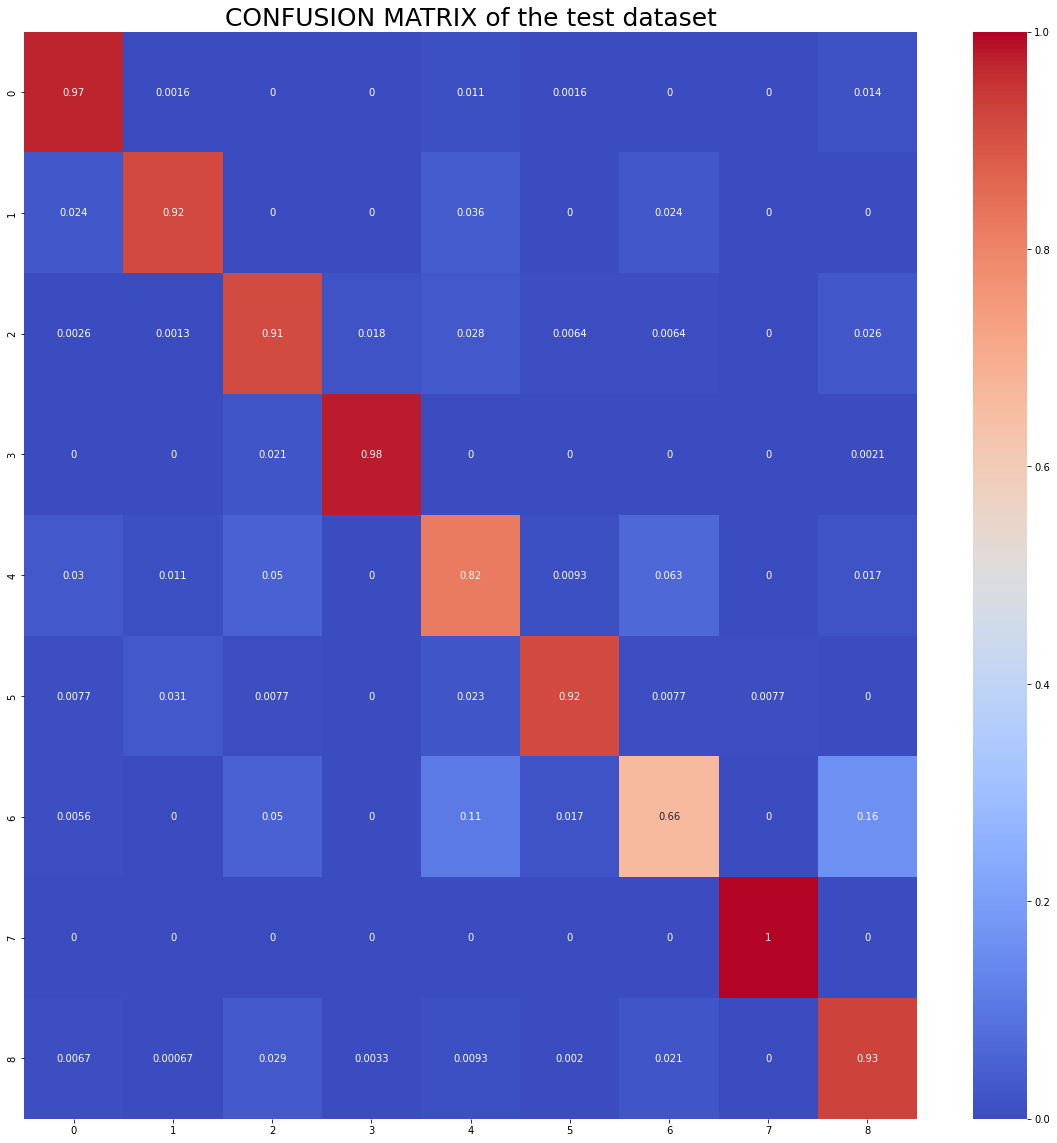

In [9]:
test(model, test_loader)

In [10]:
import shap

sample = next(iter(test_loader))['img']
sample = sample[np.random.choice(sample.shape[0], 100, replace=False)].float().to(device)

In [11]:
model(sample).shape

torch.Size([100, 9])

In [12]:
explainer = shap.DeepExplainer(model, sample)
shap_values = explainer.shap_values(sample)
shap.image_plot(shap_values, sample)

RuntimeError: The size of tensor a (512) must match the size of tensor b (2048) at non-singleton dimension 1

In [31]:
test_dataset[0]

{'img': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'label': 4.0}

In [21]:
len(test_dataset)

5328

array([3899, 2650, 2174,  402, 3503, 3781, 3925, 2331, 4300, 4593, 3033,
        915,  977, 2680, 4541,  172, 4262,  640, 3727, 4752, 4506, 1521,
       5113, 4865,  934, 3686, 2311, 4108, 2676, 1181, 2578, 1736,   54,
       2244, 3091, 3637,  325, 2727, 1845, 1320, 1493, 3687, 4037, 5220,
       3251, 5254, 1166,  737,  722, 4604, 1235, 2785, 1090, 2584, 5143,
       3831, 4258, 2788,  921, 1844, 1489, 1523, 3913,  741, 4760, 1465,
       1434, 1179, 1538, 4328, 5240, 4781, 4934, 2114, 4579, 2270, 2077,
       3998, 4873,  582, 3553, 3029, 1420,  473, 3924, 4066,   78,  531,
       2942, 2021, 1699, 4410, 1506, 5116, 3168, 4107, 4214, 4900, 3816,
        700])